In [3]:
# https://qiskit.org/textbook/ch-quantum-hardware/transmon-physics.html#3.-Quantizing-the-Hamiltonian-

import numpy as np
import matplotlib.pyplot as plt

E_J = 20e9
w = 5e9
anharm = -300e6

N_phis = 101
phis = np.linspace(-np.pi,np.pi,N_phis)
mid_idx = int((N_phis+1)/2)

# potential energies of the QHO & transmon
U_QHO = 0.5*E_J*phis**2
U_QHO = U_QHO/w
U_transmon = (E_J-E_J*np.cos(phis))
U_transmon = U_transmon/w

In [4]:
# import QuTiP, construct Hamiltonians, and solve for energies
# pip install qutip
from qutip import destroy
N = 35
N_energies = 5
c = destroy(N)
H_QHO = w*c.dag()*c
E_QHO = H_QHO.eigenenergies()[0:N_energies]
H_transmon = w*c.dag()*c + (anharm/2)*(c.dag()*c)*(c.dag()*c - 1)
E_transmon = H_transmon.eigenenergies()[0:2*N_energies]

In [5]:
print(E_QHO[:4])
print(E_transmon[:8])

[0.0e+00 5.0e+09 1.0e+10 1.5e+10]
[0.00e+00 1.70e+09 5.00e+09 6.60e+09 9.70e+09 1.12e+10 1.41e+10 1.55e+10]


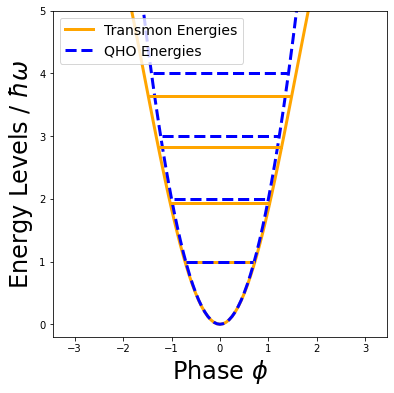

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

axes.plot(phis, U_transmon, '-', color='orange', linewidth=3.0)
axes.plot(phis, U_QHO, '--', color='blue', linewidth=3.0)

for eidx in range(1,N_energies):
    delta_E_QHO = (E_QHO[eidx]-E_QHO[0])/w
    delta_E_transmon = (E_transmon[2*eidx]-E_transmon[0])/w
    QHO_lim_idx = min(np.where(U_QHO[int((N_phis+1)/2):N_phis] > delta_E_QHO)[0])
    trans_lim_idx = min(np.where(U_transmon[int((N_phis+1)/2):N_phis] > delta_E_transmon)[0])
    trans_label, = axes.plot([phis[mid_idx-trans_lim_idx-1], phis[mid_idx+trans_lim_idx-1]], \
                             [delta_E_transmon, delta_E_transmon], '-', color='orange', linewidth=3.0)
    qho_label, = axes.plot([phis[mid_idx-QHO_lim_idx-1], phis[mid_idx+QHO_lim_idx-1]], \
                           [delta_E_QHO, delta_E_QHO], '--', color='blue', linewidth=3.0)
    
axes.set_xlabel('Phase $\phi$', fontsize=24)
axes.set_ylabel('Energy Levels / $\hbar\omega$', fontsize=24)
axes.set_ylim(-0.2,5)

qho_label.set_label('QHO Energies')
trans_label.set_label('Transmon Energies')
axes.legend(loc=2, fontsize=14)

In [7]:
# https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html#1.-Getting-Started-

import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

In [8]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [12]:
backend_config = backend.configuration()
#assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [13]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [14]:
backend_defaults = backend.defaults()

In [15]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0
# We will define memory slot channel 0.
mem_slot = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.962293331723022 GHz.
The sweep will go from 4.942293331723023 GHz to 4.982293331723023 GHz in steps of 1.0 MHz.


In [16]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [17]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of_16(sec/dt)

In [18]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.


# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05


# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    # Define our measurement pulse
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
        

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

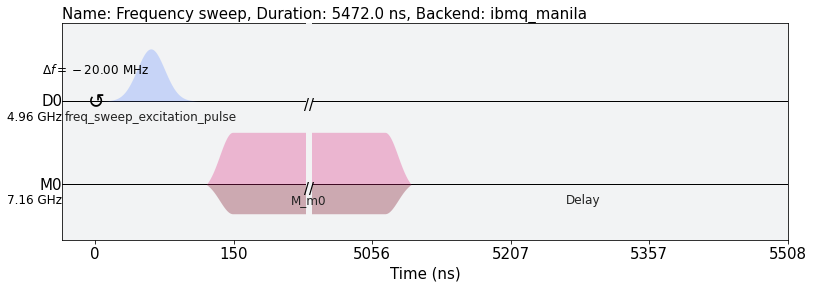

In [19]:
schedules[0].draw(backend=backend)